In [1]:
### ATOC5860 - eof_example_NH_PSL_cartopy
### Coded by Jennifer Kay with help from Elizabeth Maroon, Vineel Yettella (University of Colorado)
### Last updated February 23, 2022 (after class in Spring 2022)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd  # library for data analysis for text files (everything but netcdf files)
import xarray  #package that open and manipulates netcdf files
import matplotlib.dates as mdates
import numpy.linalg as LA
from matplotlib.gridspec import GridSpec
import timeit
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [2]:
### Read in the data
print('read in the monthly data from CESM')
fid=xarray.open_dataset('b.e11.B20TRC5CNBDRD.f09_g16.003.cam.h0.PSL.192001-200512.nc')
#print(fid)
### Note: CAM writes out the time as the end time.  
### See https://ncar.github.io/CAM/doc/build/html/users_guide/model-output.html - 7.4 Timestamps and time intervals
### We want to use the beginning of the month. We can use the time_bnds variable to get replace time.
tbounds=fid['time_bnds'].isel(nbnd=0) ##  pick out beginning of bound, first index of bound.
fid['time']=tbounds.values  ## replace time with beginning of bound.
print(fid['time']) ## check that the first time is now Jan 1.
lon=fid["lon"]
lat=fid["lat"]
time=fid["time"]
global_data=fid["PSL"] ## original data are in Pascals
print("shape of global data",np.shape(global_data))
#print(np.shape(time))

read in the monthly data from CESM
<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1920, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1920, 3, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2005, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
shape of global data (1032, 192, 288)


In [3]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS

### Subset the data
print('subset to just Northern Hemisphere')
minlat=20
maxlat=90
minlon=0
maxlon=360
nh_data=fid["PSL"].sel(lat=slice(minlat,maxlat)).sel(lon=slice(minlon,maxlon))
nh_lon=fid["lon"].sel(lon=slice(minlon,maxlon))
nh_lat=fid["lat"].sel(lat=slice(minlat,maxlat))
#nh_data=nh_data[0:12*nyrs,:,:]
print(f'type of data - should be xarray DataArray: {type(nh_data)}') ## check that the data is Xarray

### this would work with numpy or xarray arrays.
#print("shape of data",np.shape(nh_data))
#index=sorted(np.concatenate((range(0,len(nh_data),12),range(1,len(nh_data),12),range(11,len(nh_data),12))))
#print(np.shape(index))
#print(index)
#nh_data=nh_data[index,:,:] 

## check the shape of the data after spatial subsetting
print(f'shape of spatially subsetted data: {np.shape(nh_data)}')

### Let's try the slicker away with Xarray
nh_data=nh_data.sel(time=slice('1920-01-01','1970-01-01'))
nh_data = nh_data[nh_data['time.season'] == 'DJF']
print(nh_data.shape)

### try summer months or just December
#nh_data = nh_data[nh_data['time.season'] == 'JJA']
#nh_data=nh_data[::12,:,:]

### weight the data by the square root of the cosine, Following Hannachi et al. 2007 pg 1123
### note: SVD and eigenanalysis give same results when you weight the data matrix by sqrt(cosine(lat))
#print(lat)
nh_data=nh_data*np.sqrt(np.cos(lat*np.pi/180)) ##np.sqrt(np.cos(nh_lat*np.pi/180))

X=nh_data/100 ## convert from Pa to mb or hPa
print(f'check shape of X (month, lat, lon): {np.shape(nh_data)}')

subset to just Northern Hemisphere
type of data - should be xarray DataArray: <class 'xarray.core.dataarray.DataArray'>
shape of spatially subsetted data: (1032, 75, 288)
(151, 75, 288)
check shape of X (month, lat, lon): (151, 75, 288)


In [4]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS

## Flatten the [lat,lon] grid into time x location shape
## Reshape the data
a,b,c=np.shape(X)
print(a,b,c)
Y=X.values.reshape(a,b*c)

## remove the sample mean 
sample_mean = X.mean('time');
X_removemean= X - sample_mean

## divide by the standard deviation
X_stand= X_removemean/(X_removemean.std('time'));
#print(np.shape(X_stand.values))

## WARNING: the code below us wrong - it is using the mean not the local standard deviation
##sample_std = np.std(X)
##print(sample_std)
##X_stand=(X_removemean/sample_std)

151 75 288


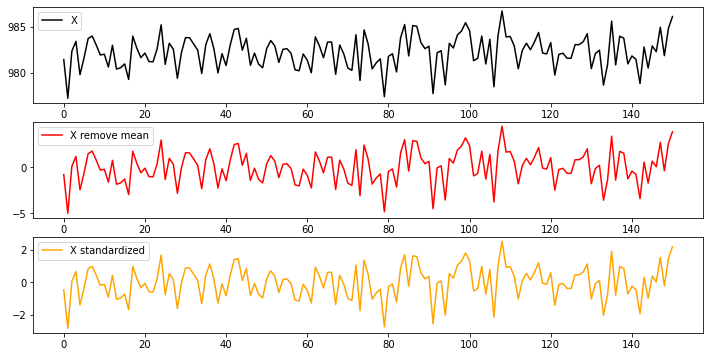

In [5]:
## Plot one point to make sure the data have the mean removed and have been standardized
## Check to make sure this happened locally as I was having some issues with the programming
## and instead was removing the entire sample mean
f=plt.figure(figsize=(12,6))
gs=GridSpec(3,1)
plt.subplot(gs[0,0])
plt.plot(X[:,1,1],label='X',color='black')
plt.legend()
plt.subplot(gs[1,0])
plt.plot(X_removemean[:,1,1],label='X remove mean',color='red')
plt.legend()
plt.subplot(gs[2,0])
plt.plot(X_stand[:,1,1],label='X standardized',color='orange')
plt.legend();

In [7]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS (continued)

## Flatten the [lat,lon] grid into time x location shape
## this takes some time since the array is big 151 x 75 x 288 -> 151 x 21600
Y_stand=X_stand.values.reshape(a,b*c)
print(np.shape(Y_stand))

##plot the standardized and original time series for one location
#f=plt.figure(figsize=(12,3))
#plt.plot(X.values.reshape(a,b*c)[:,1],label='X',color='black');
#plt.plot(Y_stand[:,1],label='X standardized',color='orange');
#plt.legend()

### At the end of this first step you want two matrices ready for EOF analysis:
### Y_stand = standardized data, dimensioned (time,location)
### Y = original data, dimensioned (time,location)
### everything below in the code assumes that you have Y_stand, Y defined as above

(151, 21600)


In [ ]:
### STEP #2 - Calculate the EOFs -- Using eigenanalysis of the covariance matrix (the np.linalg.eig method)
##(don't do this, 21600 in the structure dimension -- this is going to crash your computer)

In [8]:
### STEP #2 - Calculate the EOFs -- Using Singular Value Decomposition (SVD) (the np.linalg SVD method)
### Why is this method so much faster?
### Note the option to set full_matrics=False.  You don't need to find 21600 EOFs!
## This option set to false limits the number of EOFs to the sampling dimension (here 151)
## from vineel [eofs, s, v] = np.linalg.svd(X.T, full_matrices=False) 

start_time = timeit.default_timer()
u,s,v=LA.svd(Y_stand,full_matrices=False)  ## Barnes Chapter 3 Equation (65)
elapsed = timeit.default_timer() - start_time
print('Time elapsed in LA SVD method: ',elapsed,' seconds')
print(np.shape(u))

Time elapsed in LA SVD method:  0.12446312099999801  seconds
(151, 151)


Percent variance explained by EOF1 in CESM: 27.0 %
Percent variance explained by EOF1 in Obs: 21%
Percent variance explained by EOF2 in CESM: 10.0 %
Percent variance explained by EOF2 in Obs:  13%


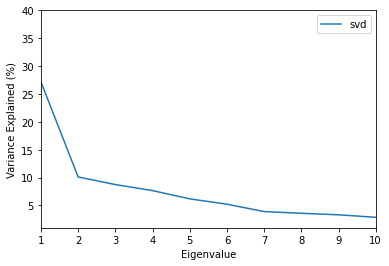

In [9]:
### STEP #3 - Plot the eigenvalues
## here there are not errors bars following North et al. 1982 - should add them in the future

# convert eigenvalues to percent variance explained
pve2 = 100.*np.abs(s**2)/np.sum(np.abs(s**2))
print('Percent variance explained by EOF1 in CESM:',np.round(pve2[0],0),'%')
print('Percent variance explained by EOF1 in Obs:','21%')
print('Percent variance explained by EOF2 in CESM:',np.round(pve2[1],0),'%')
print('Percent variance explained by EOF2 in Obs:  13%')
## Hannachi et al. 2007 report observations show EOF1=21% variance, EOF2=13% variance

f=plt.figure();
plt.plot(np.arange(1,len(pve2)+1),pve2,label='svd');
plt.ylim([1,40]);
plt.xlim([1,10]);
plt.ylabel('Variance Explained (%)');
plt.xlabel('Eigenvalue');
plt.legend();

In [13]:
### STEP 4 - Find the first two EOF patterns and PC timeseries 

# select an EOF
eof_num=1

# Find the eigenvector (e1) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e1 = (v[eof_num-1,:]).reshape(b,c)
print(np.shape(e1))

# Calculate the principal component (z1) associated with "eof_num" from the SVD method
z1 = u[:,eof_num-1]  ###note: *(s[eof_num-1]) deleted
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(np.shape(z1))

# select an EOF
eof_num=2

# Find the eigenvector (e1) associated with "eof_num" from the SVD method
e2 = (v[eof_num-1,:]).reshape(b,c)
print(np.shape(e1))

# Calculate the principal component (z1) associated with "eof_num" from the SVD method
z2 = u[:,eof_num-1] ###note: *(s[eof_num-1]) deleted
## standardize it
z2 = (z2-np.mean(z2))/np.std(z2)  
print(np.shape(z2))

(151, 21600) (151,) (151, 151)
(75, 288)
(151,)
(75, 288)
(151,)


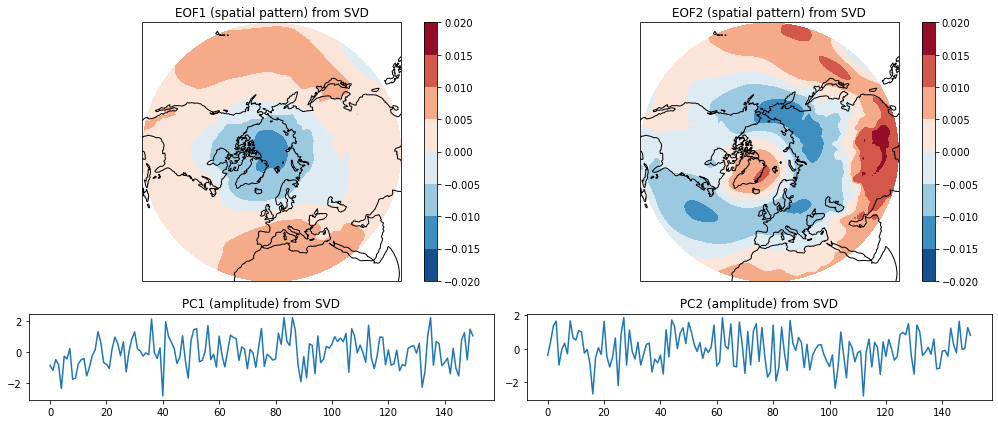

In [14]:
### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(14,6))
gs=GridSpec(2,2,height_ratios=(3,1))

e1plot,lonplot=add_cyclic_point(e1,coord=lon.values)
levels=np.arange(-0.02,0.021,0.005)
ax=plt.subplot(gs[0,0],projection=ccrs.Stereographic(central_latitude=90,central_longitude=0))
CS=plt.contourf(lonplot,lat.sel(lat=slice(20,90)),e1plot,levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())  ##PlateCarree = Lat/Lon?
ax.set_extent([-180,180,20,90],crs=ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF1 (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot((z1))
plt.title('PC1 (amplitude) from SVD')

e2plot,lonplot=add_cyclic_point(e2,coord=lon.values)
ax=plt.subplot(gs[0,1],projection=ccrs.Stereographic(central_latitude=90,central_longitude=0))
CS=plt.contourf(lonplot,lat.sel(lat=slice(20,90)),e2plot,levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())  ##PlateCarree = Lat/Lon?
ax.set_extent([-180,180,20,90],crs=ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF2 (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot((z2))
plt.title('PC2 (amplitude) from SVD')

plt.tight_layout() ## removes overlap between figure panels

In [15]:
### STEP 5) Regress the data (unweighted data if applicable) onto standardize values of the PC 
### for eof_num above

# calculate d for plotting in physical units, not standardized/weighted units.
## d1 is in physical units (in this case degrees) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
#print(np.max(X.values))
#print(np.min(X.values))
#print(np.shape(Yorig))
#print(np.shape(np.transpose(z)))
d1 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z1),Y)   ## Barnes Chapter 3 Equation (79)
#print(np.shape(d1))
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot
print(np.shape(d1plot))
print(min(d1))
print(max(d1))
d2 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z2),Y)   ## Barnes Chapter 3 Equation (79)
d2plot = d2.reshape(b,c)  ### this is the reshaped eigenvector to plot

# calculate d for plotting in standardized/weighted units
## d1s is in standardized units (in other words, no units) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
d1s = (1./np.size(Y_stand,axis=0))*np.dot(np.transpose(z1),Y_stand)
#print(np.shape(d1))
d1splot = d1s.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1splot))
print(min(d1s))
print(max(d1s))
d2s = (1./np.size(Y_stand,axis=0))*np.dot(np.transpose(z2),Y_stand)
d2splot = d2s.reshape(b,c)  ### this is the reshaped eigenvector to plot

(75, 288)
-3.940642728014293
3.1254407937920634
-0.8836877405895899
0.6109173841333749


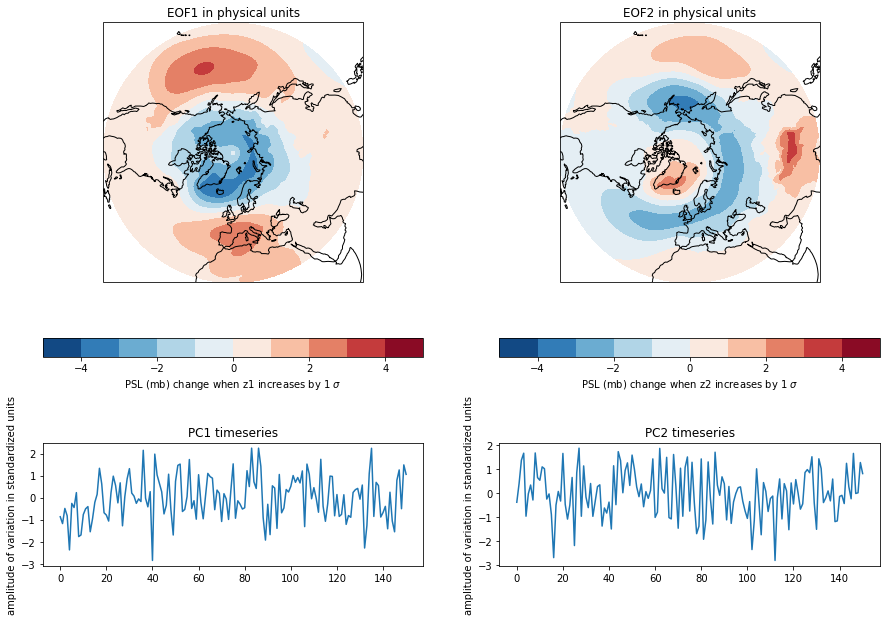

In [16]:
### Make a 4-panel plot
#print(np.shape(np.transpose(d1.reshape(b,c))))

f=plt.figure(figsize=(15,10))
gs=GridSpec(2,2,height_ratios=(3,1))

d1plotme,lonplot=add_cyclic_point(d1plot,coord=lon.values)
levels2=np.arange(-5.0,5.1,1)
ax=plt.subplot(gs[0,0],projection=ccrs.Stereographic(central_latitude=90,central_longitude=0))
CS=plt.contourf(lonplot,lat.sel(lat=slice(20,90)),d1plotme,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())  ##PlateCarree = Lat/Lon?
ax.set_extent([-180,180,20,90],crs=ccrs.PlateCarree())
ax.coastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('PSL (mb) change when z1 increases by 1 $\sigma$')
plt.title('EOF1 in physical units')
plt.subplot(gs[1,0])
plt.plot(z1)
plt.ylabel('amplitude of variation in standardized units')
plt.title('PC1 timeseries')

d2plotme,lonplot=add_cyclic_point(d2plot,coord=lon.values)
ax=plt.subplot(gs[0,1],projection=ccrs.Stereographic(central_latitude=90,central_longitude=0))
CS=plt.contourf(lonplot,lat.sel(lat=slice(20,90)),d2plotme,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())  ##PlateCarree = Lat/Lon?
ax.set_extent([-180,180,20,90],crs=ccrs.PlateCarree())
ax.coastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('PSL (mb) change when z2 increases by 1 $\sigma$')
plt.title('EOF2 in physical units')
plt.subplot(gs[1,1])
plt.plot(z2)
plt.ylabel('amplitude of variation in standardized units')
plt.title('PC2 timeseries');
